In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_path = "../../data/MOBA_scRNAseq/outs_S3"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1652 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [5]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1652 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.936
Zero inflation of aggregated data: 0.831


### Filter cells

--> filter based on mean absolute standard deviation

In [7]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    1544
True      108
Name: outlier, dtype: int64
Total number of cells: 1652
Number of cells after filtering: 1544


AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

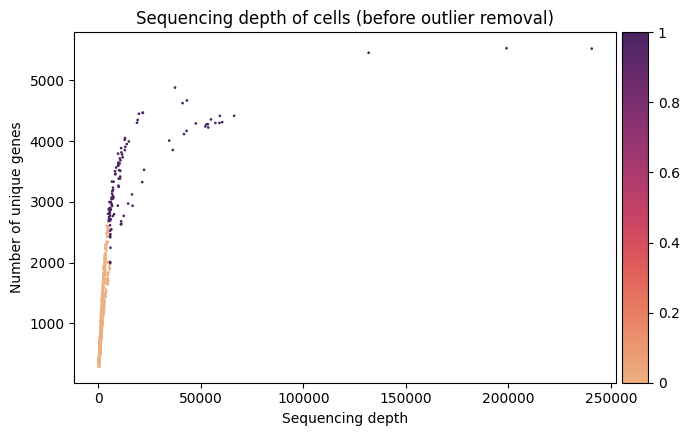

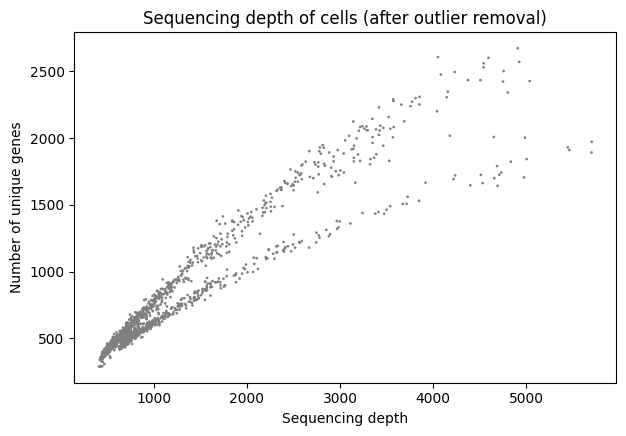

In [8]:
g = sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [9]:
data_gene.layers["counts"] = data_gene.X.copy()

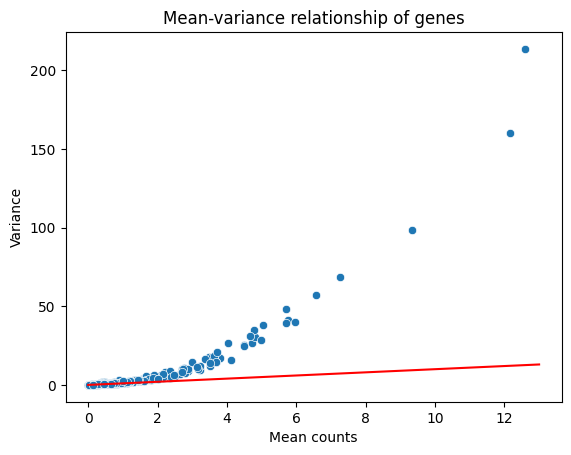

In [10]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [11]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

True


## Estimate negative binomial parameters for each gene

In [12]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=1234)

In [13]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
PA0001  Gene Expression   PA01                735     0.666451   
PA0002  Gene Expression   PA01                541     0.468912   
PA0003  Gene Expression   PA01                890     0.893782   
PA0004  Gene Expression   PA01                463     0.373705   
PA0005  Gene Expression   PA01                173     0.120466   
...                 ...    ...                ...          ...   
PA5566  Gene Expression   PA01                 14     0.009715   
PA5567  Gene Expression   PA01                163     0.126943   
PA5568  Gene Expression   PA01                740     0.659974   
PA5569  Gene Expression   PA01               1430     3.498057   
PA5570  Gene Expression   PA01                480     0.466969   

        log1p_mean_counts  pct_dropout_by_counts  total_counts  \
PA0001           0.510696              52.396373        1029.0   
PA0002           0.384522              64.961140         724.0   
PA0003           0.638576              42.357513        1380.0   
PA0004           0.317511              70.012953         577.0   
PA0005           0.113745              88.795337         186.0   
...                   ...                    ...           ...   
PA5566           0.009668              99.093264          15.0   
PA5567           0.119509              89.443005         196.0   
PA5568           0.506802              52.072539        1019.0   
PA5569           1.503646               7.383420        5401.0   
PA5570           0.383198              68.911917         721.0   

        log1p_total_counts  n_cells  var_counts  is_scd_outlier  nb_overdisp  \
PA0001            6.937314      735    0.755973           False    18.258060   
PA0002            6.586172      541    0.588412           False    12.393082   
PA0003            7.230563      890    1.043122           False    19.546945   
PA0004            6.359574      463    0.398557           False     9.681856   
PA0005            5.231109      173    0.124089           False     2.325111   
...                    ...      ...         ...             ...          ...   
PA5566            2.772589       14    0.010916           False     0.106181   
PA5567            5.283204      163    0.161347           False     2.341030   
PA5568            6.927558      740    0.750315           False    18.196587   
PA5569            8.594525     1430   14.170981           False     6.453182   
PA5570            6.582025      480    0.746318           False    11.523542   

        nb_overdisp_cutoff    nb_mean    nb_umi  Intercept_step1_sct  \
PA0001           18.258060  -7.099251  2.189803            -6.941972   
PA0002           12.393082  -7.697277  2.258850                  NaN   
PA0003           19.546945  -6.680245  2.153070            -6.444100   
PA0004            9.681856  -8.038585  2.301814                  NaN   
PA0005            2.325111  -9.846324  2.516918            -9.978644   
...                    ...        ...       ...                  ...   
PA5566            0.106181 -11.868322  2.341862            -7.586299   
PA5567            2.341030  -9.839219  2.516340                  NaN   
PA5568           18.196587  -7.106112  2.190528                  NaN   
PA5569            6.453182  -5.554447  2.223630            -6.188664   
PA5570           11.523542  -7.797954  2.271309                  NaN   

        log_umi_step1_sct  dispersion_step1_sct  
PA0001           2.135988              0.009296  
PA0002                NaN                   NaN  
PA0003           2.071128              0.008896  
PA0004                NaN                   NaN  
PA0005           2.553776              0.010155  
...                   ...                   ...  
PA5566           0.980230              0.034549  
PA5567                NaN                   NaN  
PA5568                NaN                   NaN  
PA5569           2.421585              0.057214  
PA5570                NaN                   NaN 

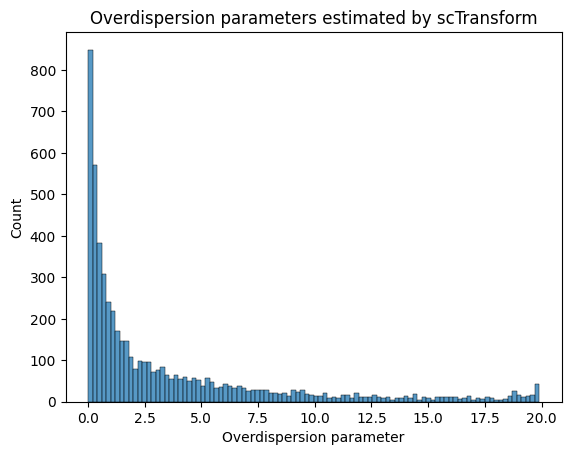

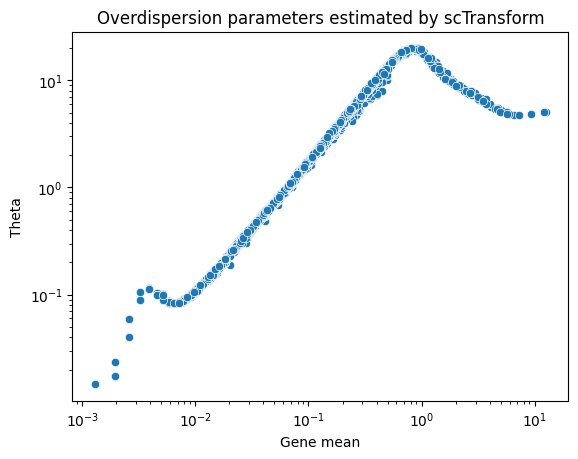

In [14]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [15]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [16]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

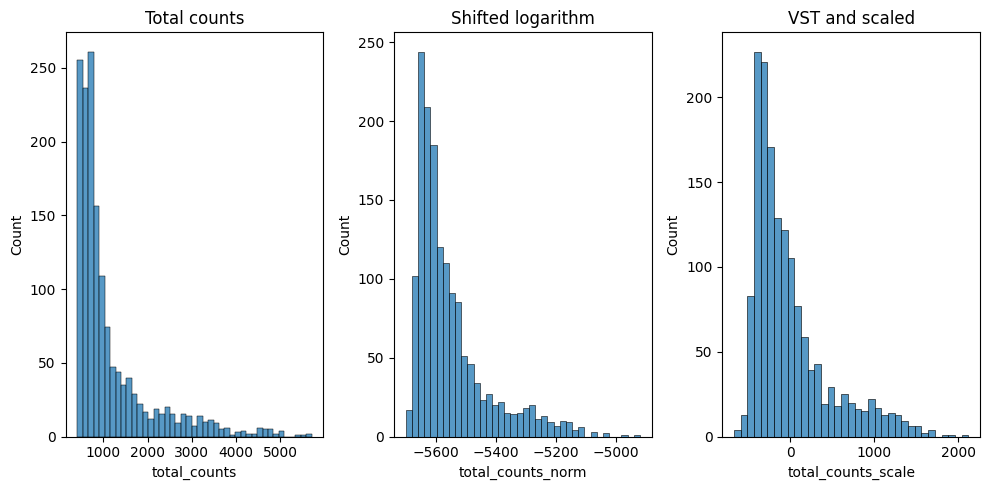

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [18]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1544 × 5513
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


In [19]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

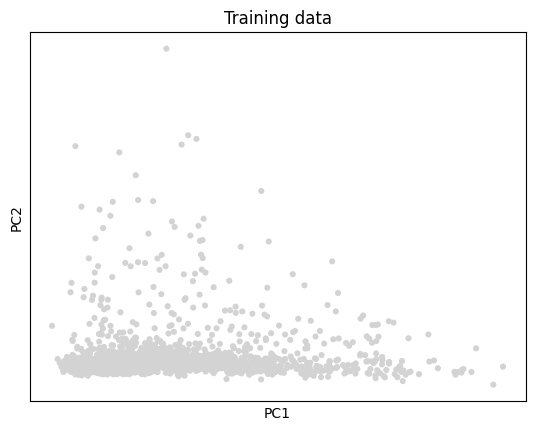

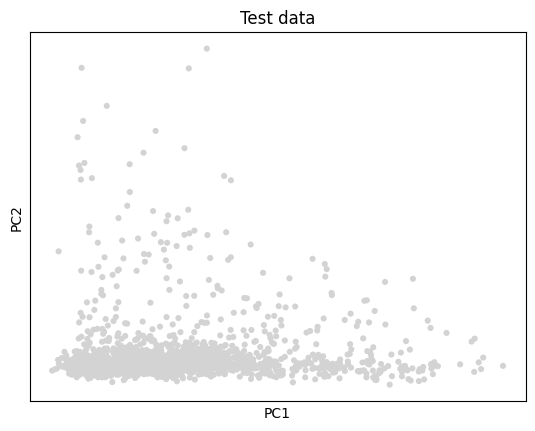

In [20]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [21]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


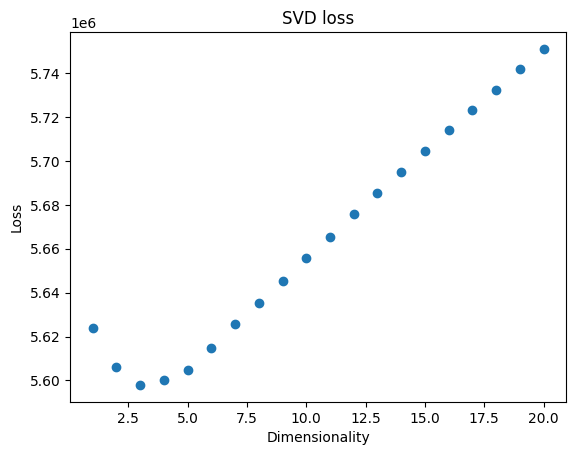

In [22]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

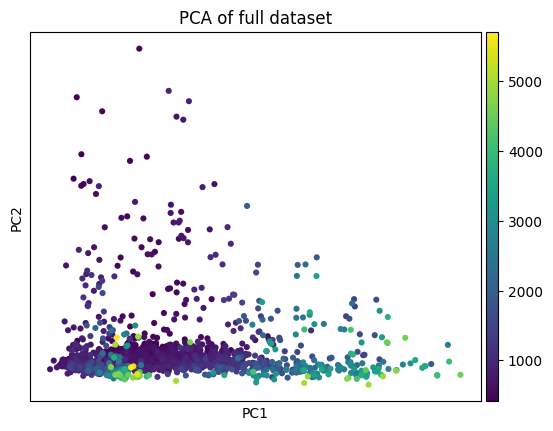

In [23]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [24]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [69]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

850


In [70]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="S3_filtered_scdeed_2")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 150
Optimal min_dist: 0.3


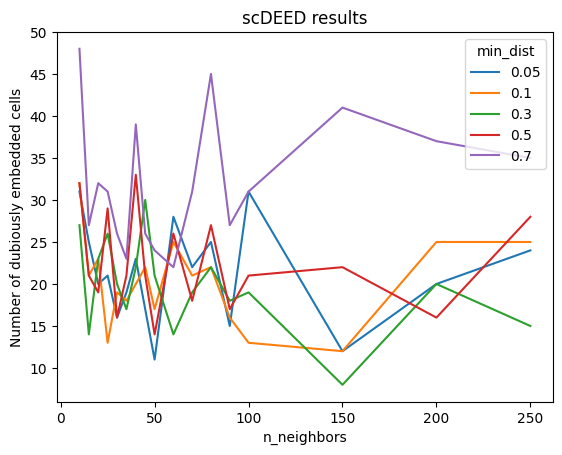

In [71]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [72]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


In [73]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [74]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


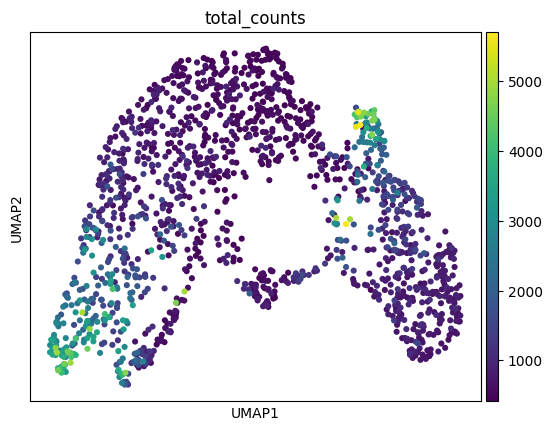

In [75]:
# sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
# plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [76]:
# data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [77]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

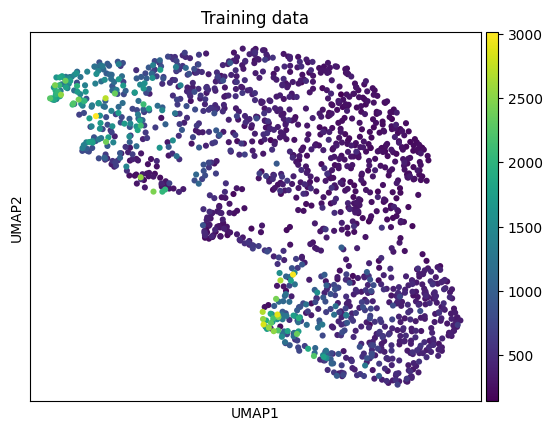

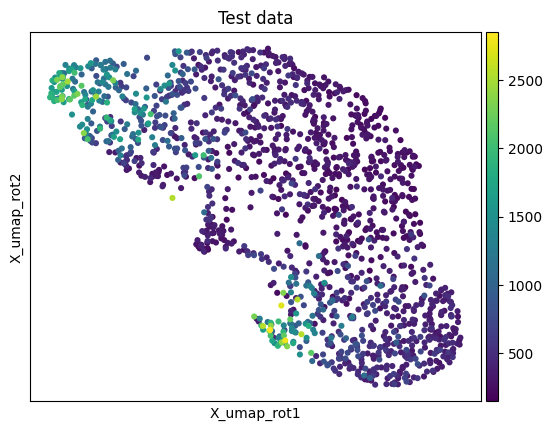

In [78]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [79]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=1234)

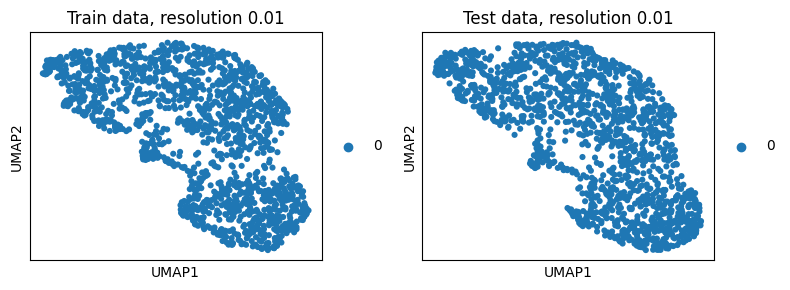

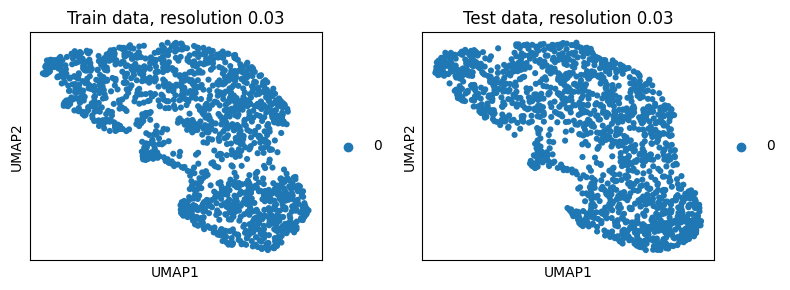

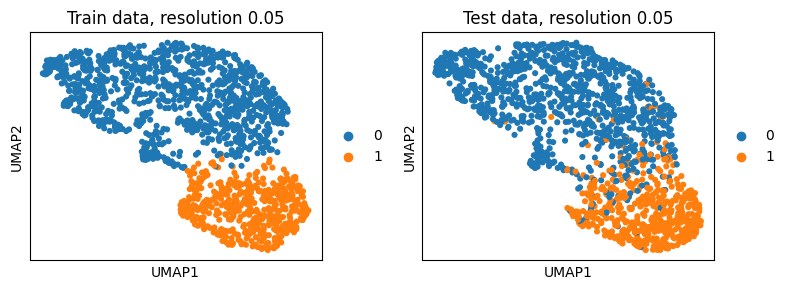

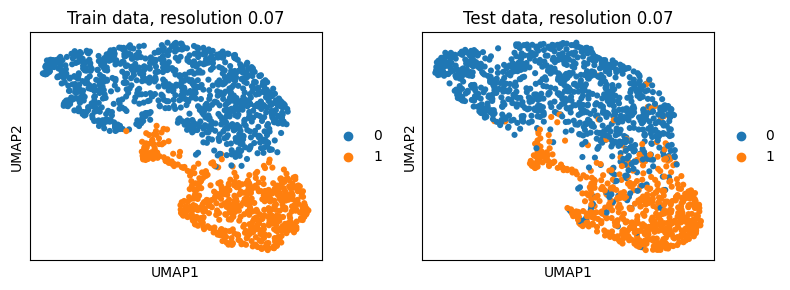

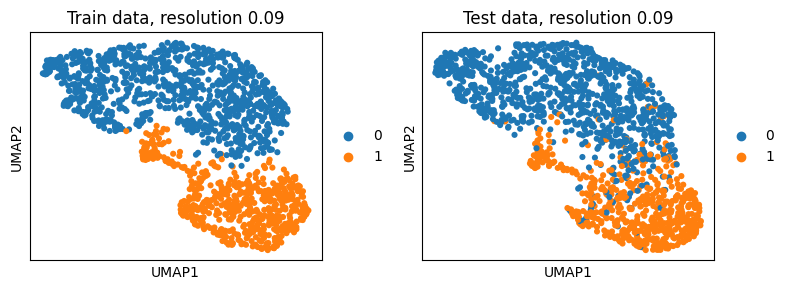

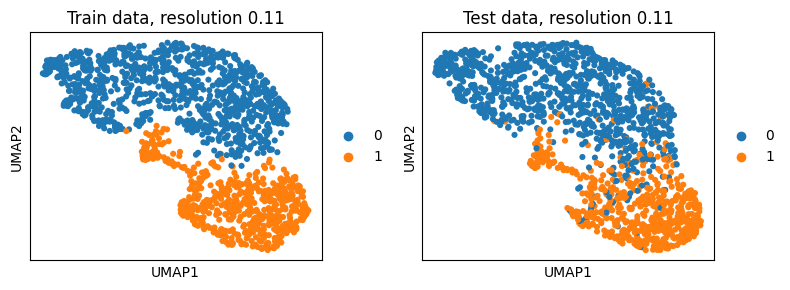

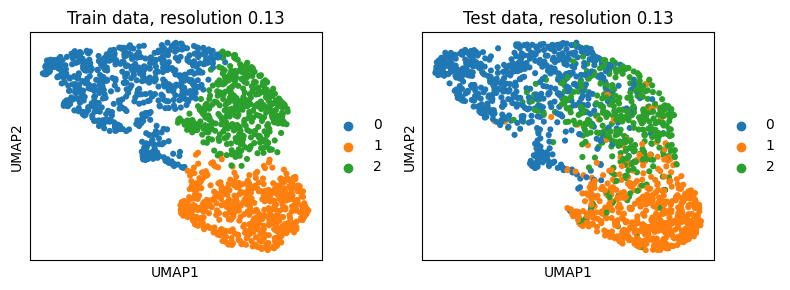

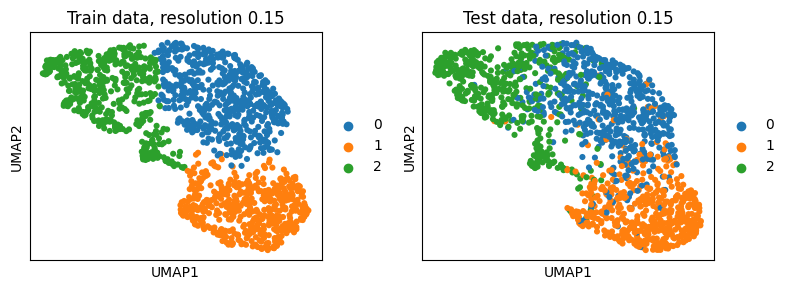

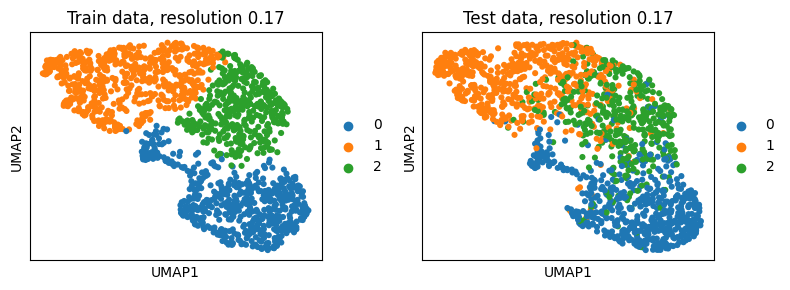

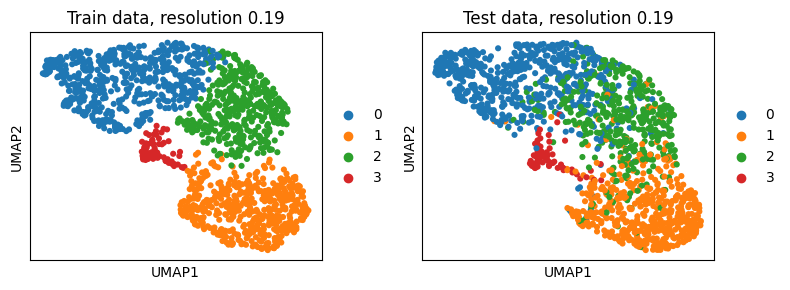

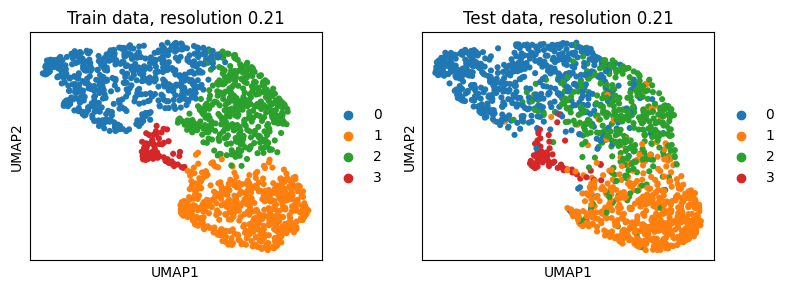

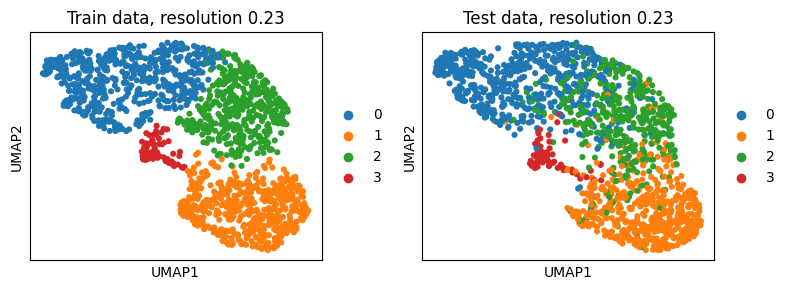

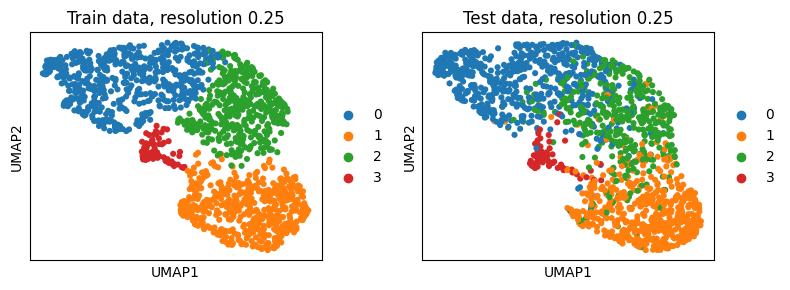

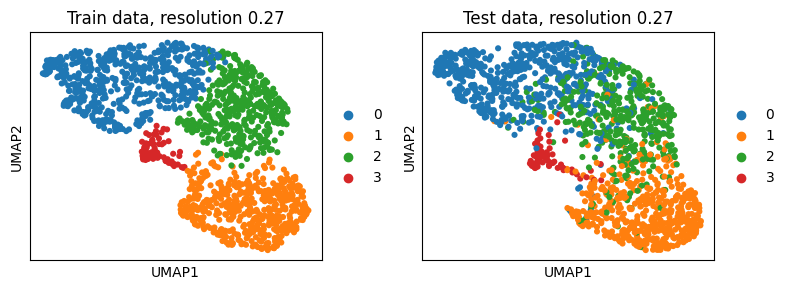

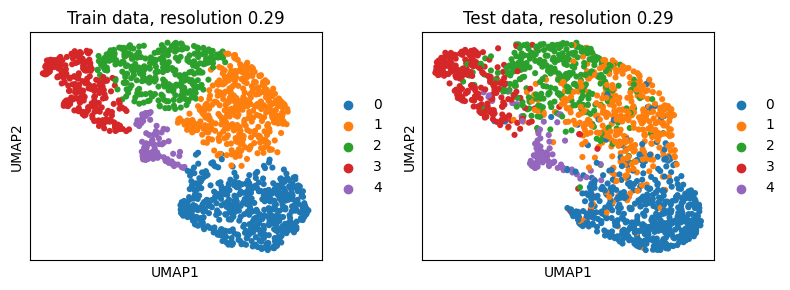

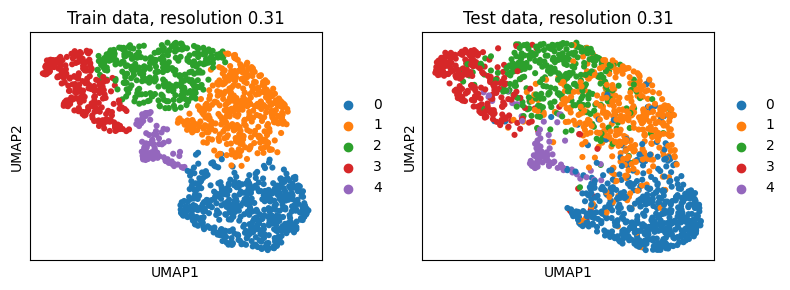

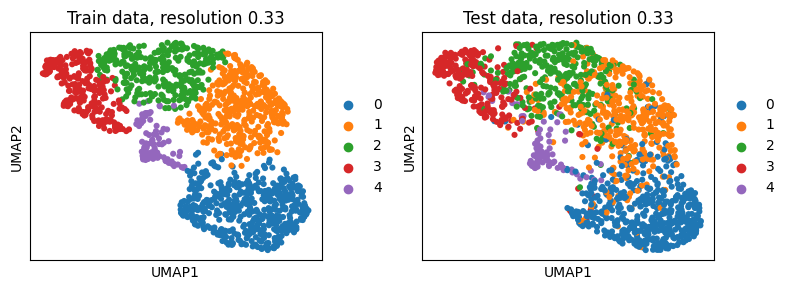

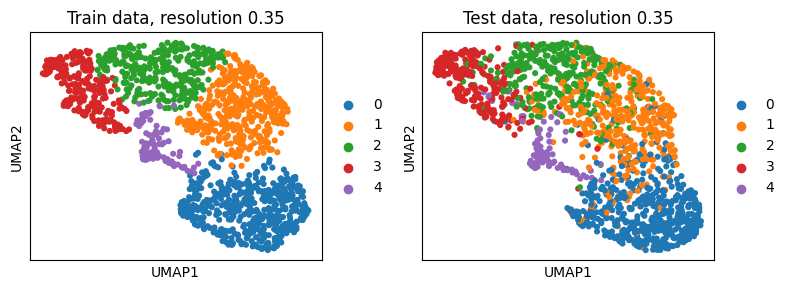

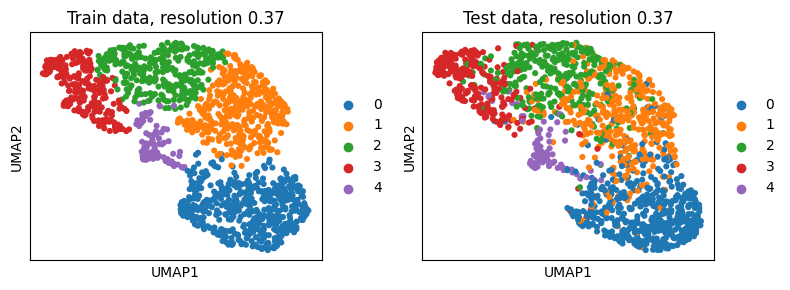

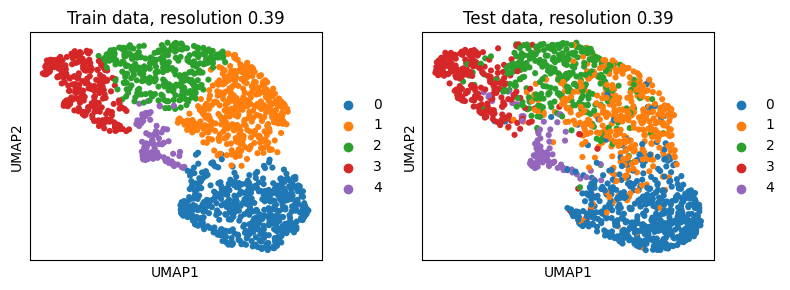

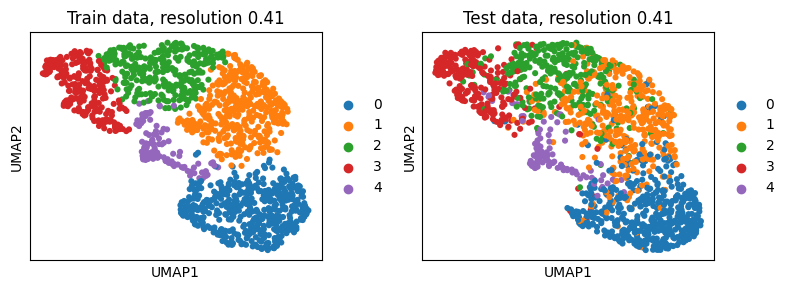

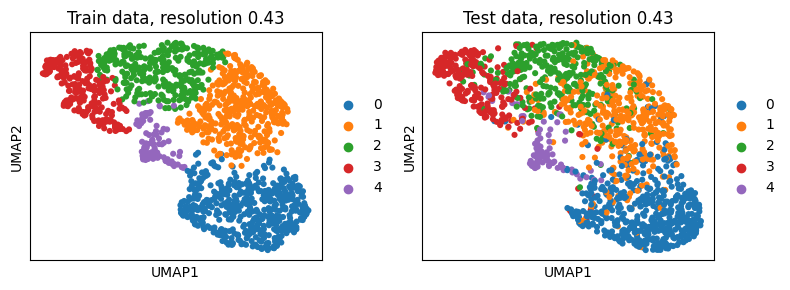

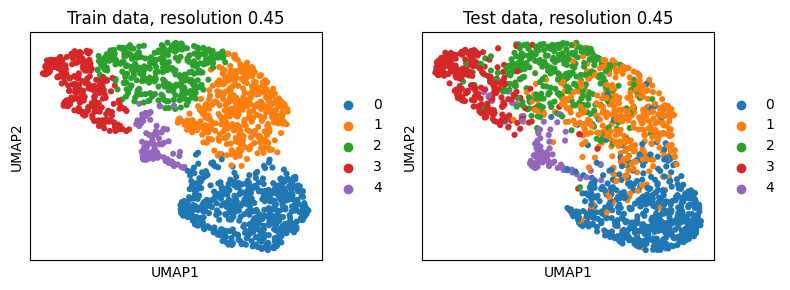

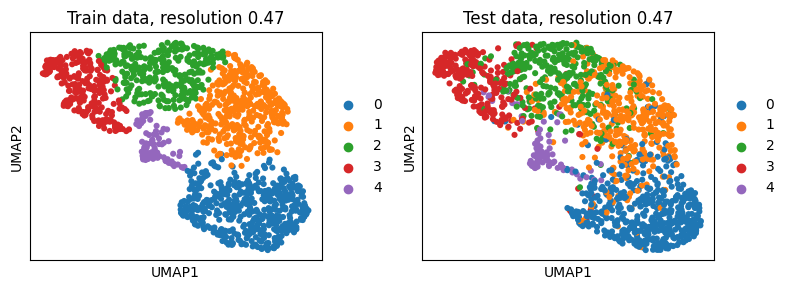

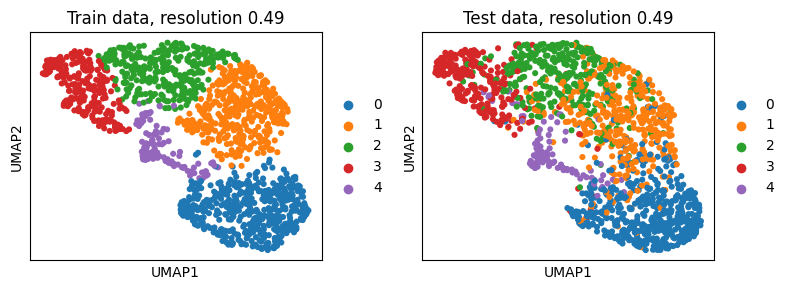

In [80]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [81]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=1234)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.442 - Test: 0.414 - Random: 0.252
resolution: 0.07 - clusters: 2 - Train: 0.429 - Test: 0.399 - Random: 0.228
resolution: 0.09 - clusters: 2 - Train: 0.418 - Test: 0.389 - Random: 0.218
resolution: 0.11 - clusters: 2 - Train: 0.407 - Test: 0.378 - Random: 0.206
resolution: 0.13 - clusters: 3 - Train: 0.389 - Test: 0.327 - Random: 0.128
resolution: 0.15 - clusters: 3 - Train: 0.382 - Test: 0.329 - Random: 0.116
resolution: 0.17 - clusters: 3 - Train: 0.378 - Test: 0.316 - Random: 0.113
resolution: 0.19 - clusters: 4 - Train: 0.367 - Test: 0.305 - Random: 0.097
resolution: 0.21 - clusters: 4 - Train: 0.361 - Test: 0.299 - Random: 0.089
resolution: 0.23 - clusters: 4 - Train: 0.354 - Test: 0.293 - Random: 0.083
resolution: 0.25 - clusters: 4 - Train: 0.348 - Test: 0.286 - Random: 0.077
resolution: 0.27 -

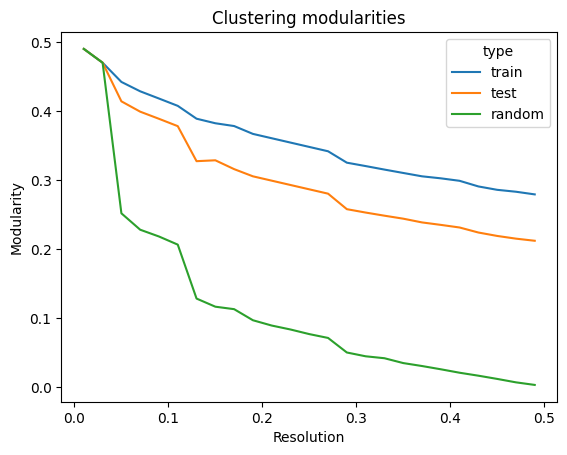

In [82]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

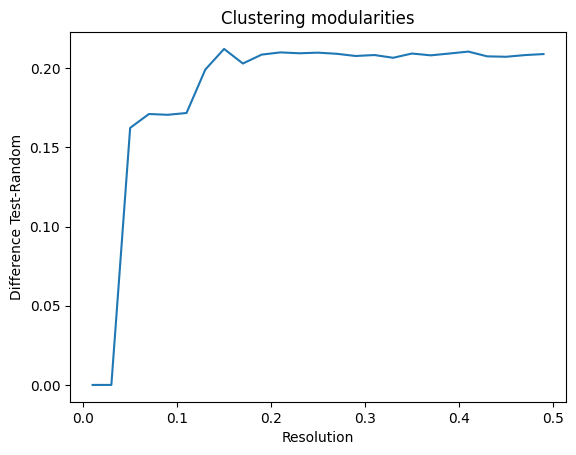

In [83]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [84]:
result_path = "S3_filtered_clustering_2"
if not os.path.exists(result_path):
    os.makedirs(result_path)
    
mod_df.to_csv(result_path + "/modularities.csv")
mod_df_wide.to_csv(result_path + "/modularities_wide.csv")

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [85]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt", random_state=1234)

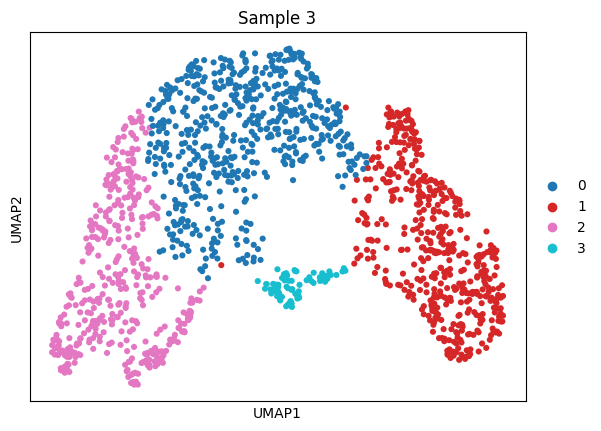

In [86]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [87]:
# data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")

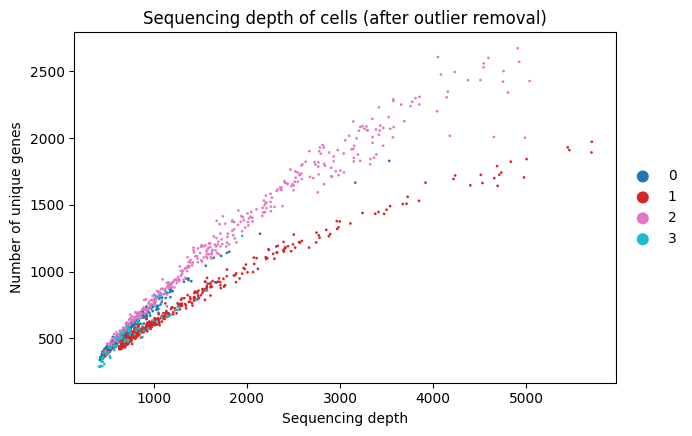

In [88]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

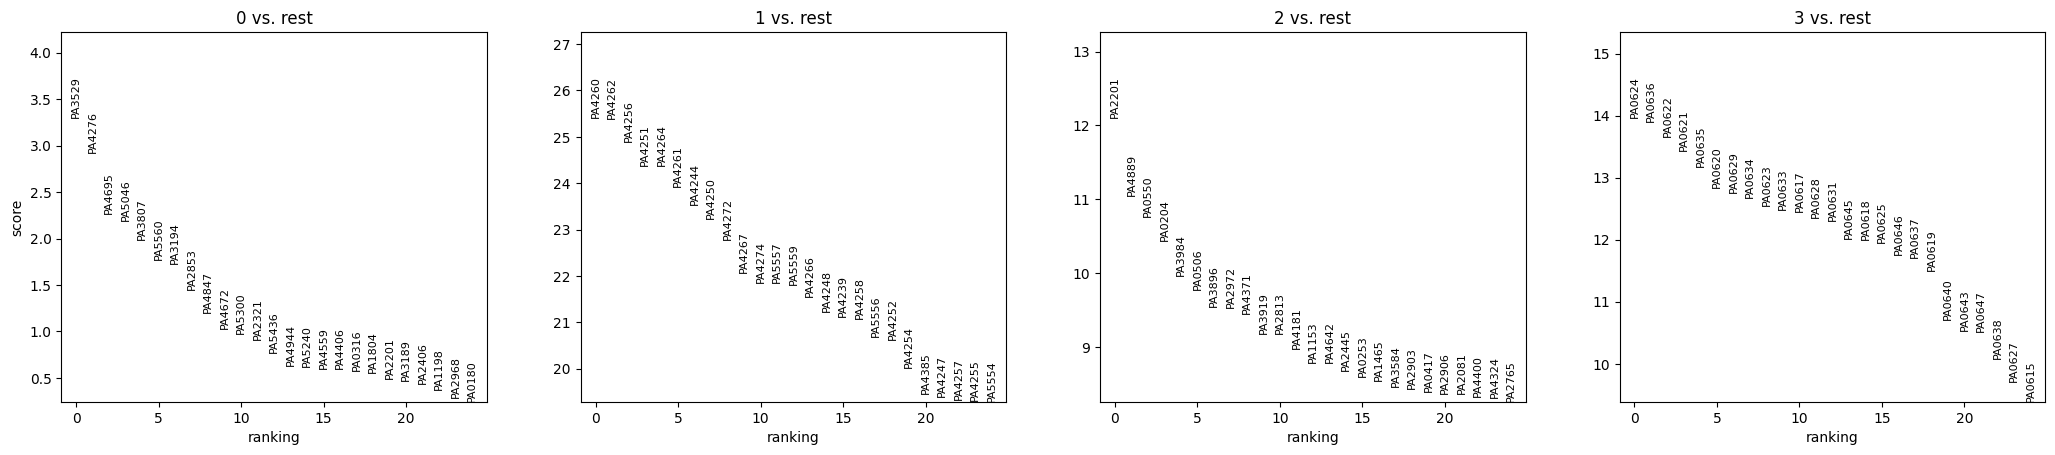

In [89]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

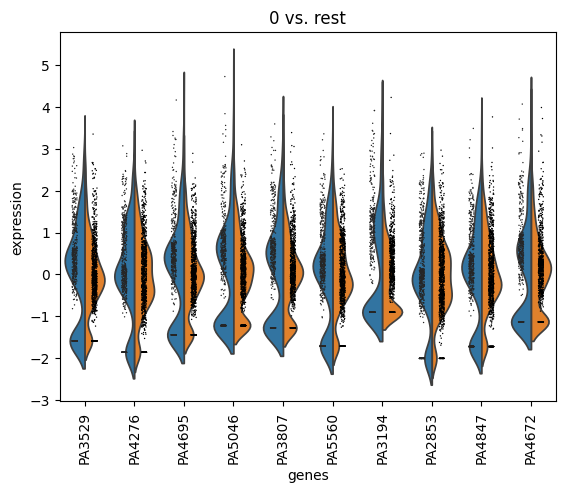

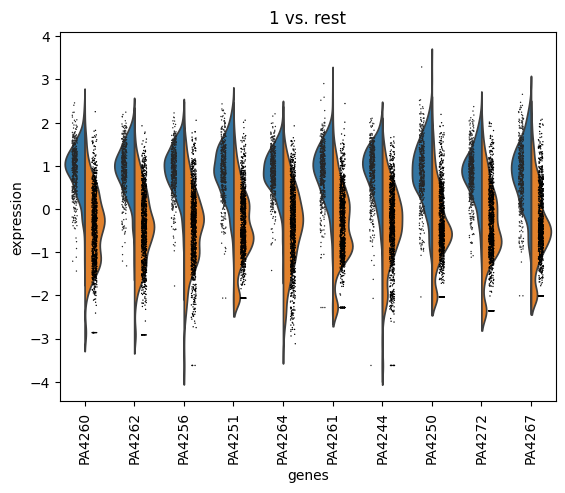

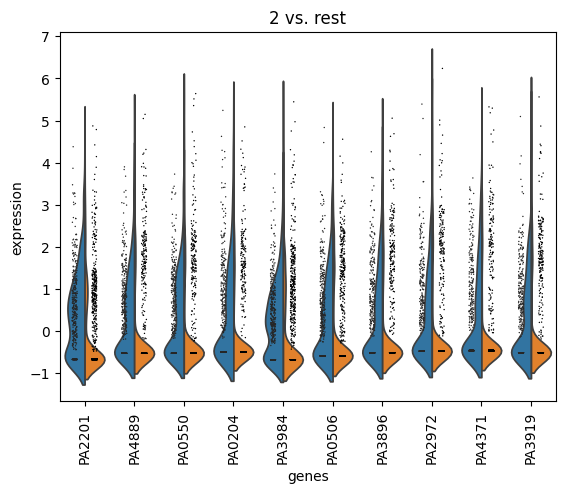

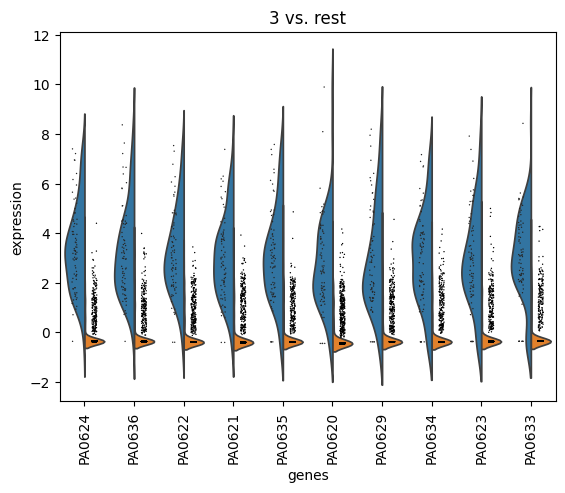

In [90]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

## Attach feature table

In [91]:
data_path = "../../data/MOBA_scRNAseq/outs_S3"
# data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'Locus tag_x', 'Protein accession_x', 'Name_x', 'Symbol_x', 'Locus tag_y', 'Protein accession_y', 'Name_y', 'Symbol_y'
    uns: 'pca', 'BacSC_params', 'neighbors', 'umap', 'leiden_opt', 'leiden_opt_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'distances', 'connectivities'

In [92]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
index                                                            
PA0001  Gene Expression   PA01                735     0.666451   
PA0002  Gene Expression   PA01                541     0.468912   
PA0003  Gene Expression   PA01                890     0.893782   
PA0004  Gene Expression   PA01                463     0.373705   
PA0005  Gene Expression   PA01                173     0.120466   
...                 ...    ...                ...          ...   
PA5566  Gene Expression   PA01                 14     0.009715   
PA5567  Gene Expression   PA01                163     0.126943   
PA5568  Gene Expression   PA01                740     0.659974   
PA5569  Gene Expression   PA01               1430     3.498057   
PA5570  Gene Expression   PA01                480     0.466969   

        log1p_mean_counts  pct_dropout_by_counts  total_counts  \
index                                                            
PA0001           0.510696              52.396373        1029.0   
PA0002           0.384522              64.961140         724.0   
PA0003           0.638576              42.357513        1380.0   
PA0004           0.317511              70.012953         577.0   
PA0005           0.113745              88.795337         186.0   
...                   ...                    ...           ...   
PA5566           0.009668              99.093264          15.0   
PA5567           0.119509              89.443005         196.0   
PA5568           0.506802              52.072539        1019.0   
PA5569           1.503646               7.383420        5401.0   
PA5570           0.383198              68.911917         721.0   

        log1p_total_counts  n_cells  var_counts  ...      mean       std  \
index                                            ...                       
PA0001            6.937314      735    0.755973  ...  1.608961  0.117723   
PA0002            6.586172      541    0.588412  ...  1.218036  0.144290   
PA0003            7.230563      890    1.043122  ...  1.699918  0.123697   
PA0004            6.359574      463    0.398557  ...  0.967086  0.151377   
PA0005            5.231109      173    0.124089  ... -0.462029  0.255630   
...                    ...      ...         ...  ...       ...       ...   
PA5566            2.772589       14    0.010916  ... -3.598799  0.324075   
PA5567            5.283204      163    0.161347  ... -0.453950  0.268463   
PA5568            6.927558      740    0.750315  ...  1.604943  0.117764   
PA5569            8.594525     1430   14.170981  ...  1.303480  0.373591   
PA5570            6.582025      480    0.746318  ...  1.146870  0.159302   

        Locus tag_x  Protein accession_x  \
index                                      
PA0001       PA0001          NP_064721.1   
PA0002       PA0002          NP_064722.1   
PA0003       PA0003          NP_064723.1   
PA0004       PA0004          NP_064724.1   
PA0005       PA0005          NP_064725.1   
...             ...                  ...   
PA5566       PA5566          NP_254253.1   
PA5567       PA5567          NP_254254.1   
PA5568       PA5568          NP_254255.1   
PA5569       PA5569          NP_254256.1   
PA5570       PA5570          NP_254257.1   

                                                 Name_x  Symbol_x  \
index                                                               
PA0001            chromosome replication initiator DnaA      dnaA   
PA0002                  DNA polymerase III subunit beta      dnaN   
PA0003          DNA replication and repair protein RecF      recF   
PA0004                             DNA gyrase subunit B      gyrB   
PA0005            lysophosphatidic acid acyltransferase      lptA   
...                                                 ...       ...   
PA5566                             hypothetical protein       NaN   
PA5567                    tRNA modification GTPase TrmE       NaN   
PA5568  inner membrane protein transloca

In [93]:
feature_table = pd.read_csv("../../data/MOBA_scRNAseq/P_aeruginosa_PAO1_feature_table.tsv", sep="\t")
feature_table = feature_table[["Locus tag", "Protein accession", "Name", "Symbol"]]
feature_table["Locus tag"] = [str(x) for x in feature_table["Locus tag"]]
feature_table

Locus tag Protein accession  \
0       PA0001       NP_064721.1   
1       PA0002       NP_064722.1   
2       PA0003       NP_064723.1   
3       PA0004       NP_064724.1   
4       PA0005       NP_064725.1   
...        ...               ...   
5692    PA5566       NP_254253.1   
5693    PA5567       NP_254254.1   
5694    PA5568       NP_254255.1   
5695    PA5569       NP_254256.1   
5696    PA5570       NP_254257.1   

                                                 Name Symbol  
0               chromosome replication initiator DnaA   dnaA  
1                     DNA polymerase III subunit beta   dnaN  
2             DNA replication and repair protein RecF   recF  
3                                DNA gyrase subunit B   gyrB  
4               lysophosphatidic acid acyltransferase   lptA  
...                                               ...    ...  
5692                             hypothetical protein    NaN  
5693                    tRNA modification GTPase TrmE    NaN  
5694  inner membrane protein translocase subunit YidC    NaN  
5695                                   ribonuclease P   rnpA  
5696                        50S ribosomal protein L34   rpmH  

[5697 rows x 4 columns]

In [94]:
df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='index', right_on='Locus tag').drop_duplicates("index").set_index("index")
data_gene.var = df3


In [95]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")